In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt
from numpy.linalg import pinv

In [13]:
def ActionsGenerator(K, d, mean=None):
    """
    Generate K actions in a d-dimensional space uniformly sampled on the unit sphere.

    Parameters:
    - K (int): Number of actions to generate.
    - d (int): Dimension of the action space.
    - mean (array-like, optional): Mean vector for generating actions. Defaults to the origin.

    Returns:
    - np.ndarray: An array of shape (K, d) with K action vectors uniformly distributed on the unit sphere.
    """
    # Generate K random points from a normal distribution
    random_points = np.random.normal(size=(K, d))
    
    # Normalize each vector to lie on the unit sphere
    norms = np.linalg.norm(random_points, axis=1, keepdims=True)
    unit_sphere_points = random_points / norms

    # Optionally adjust the mean of the distribution
    if mean is not None:
        mean = np.array(mean).reshape(1, -1)  # Ensure mean is compatible with unit_sphere_points
        unit_sphere_points += mean
        # Re-normalize to ensure points still lie on the sphere
        unit_sphere_points = unit_sphere_points / np.linalg.norm(unit_sphere_points, axis=1, keepdims=True)

    return unit_sphere_points

In [14]:
class LinearBandit:
    def __init__(self, theta, K, var=1):
      """
      Args:
        theta: d-dimensional vector representing the hidden parameters
        K: number of actions per round (random action vectors generated each time)
        var: variance
      """
      self.d = np.size(theta)
      self.theta = theta
      self.K = K
      self.var = var
      self.current_action_set = np.zeros(self.d)


    def get_action_set(self):
      """
      Generates a set of vectors in dimension self.d with the action generator
      """
      self.current_action_set = ActionsGenerator(self.K, self.d)
      return self.current_action_set

    def get_reward(self, action):
      """ 
      Sample reward given action 
      Args:
        action: d-dimensional vector
      """
      mean = np.dot(action, self.theta) #compute mean
      return np.random.normal(mean, scale=self.var)

    def get_means(self):
      """
      To access the mean
      """
      return np.dot(self.current_action_set, self.theta)


In [15]:
def play(environment, agent_rpm, agent_eq, n_experiments, n_trials):
    """
    Play n_experiments trajectories over a horizon n_trials for the agent.
    Args:
        agent_rpm : the RPM agent
        agent_eq : the equal allocation agent
        n_experiments : number of experiments (Monte Carlo)
        n_trials : horizon
    """

    data_rpm = np.zeros((n_experiments, n_trials))
    data_eq = np.zeros((n_experiments, n_trials))

    for n in range(n_experiments):
        agent_rpm.reset()
        agent_eq.reset()
        for t in range(n_trials):
            action_set = environment.get_action_set()
            action_rpm = agent_rpm.get_action(action_set) # RPM allocation
            action_eq = action_set[t % len(action_set)]  # Equal allocation
            
            reward_rpm = environment.get_reward(action_rpm)
            agent_rpm.receive_reward(action_rpm,reward_rpm)
            reward_eq = environment.get_reward(action_eq)
            agent_eq.receive_reward()

            # compute instant regret
            means = environment.get_means()
            best_reward = np.max(means)
            data_rpm[n,t]= best_reward - reward_rpm 
            data_eq[n,t] = best_reward - reward_eq

    return data_rpm, data_eq


def experiment(environment, agent_rpm, agent_eq, n_experiments, n_trials):
    """
    Play n_experiments trajectories for both agents over a horizon n_traisl and store data in a dictionary
    """

    all_data = {}

    regrets_rpm, regrets_eq = play(environment, agent_rpm, agent_eq, n_experiments, n_trials)

    all_data[agent_rpm.name()] = regrets_rpm
    all_data[agent_eq.name()] = regrets_eq

    return all_data

In [64]:
K = 7
theta = [1.22,1.25,1.3] 
d = len(theta) 
sigma = 0.4


In [65]:
env = LinearBandit(theta, K, var=sigma**2)

In [66]:
class LinRPM:
    def __init__(self, d, sigma):
        """
        RPM algorithm for linear bandits.

        Args:
            d: Dimension of the action space
            sigma: Standard deviation of the noise 
            lambda_reg: Regularization parameter for the covariance matrix.
            alpha: Scaling factor for exploration (optional, typically set to 1.0).
        """
        self.d = d  # Dimension of the feature space
        self.sigma = sigma  # Noise standard deviation
        self.reset()

    def reset(self):
        """
        Reset all internal estimators and counters
        """
        self.t = 0  # Time step counter
        self.tilde_theta = np.zeros(self.d)  # Estimated parameter vector
        self.cov = np.identity(self.d) 
        self.invcov = pinv(self.cov)  
        self.Xt_yt = np.zeros(self.d)  

    def get_action(self, arms):
        """
        Choose an action using the RPM strategy.

        Parameters:
        - arms: Array of shape (K, d) representing the available actions.

        Returns:
        - The chosen action (vector of dimension d).
        """
        # Sample a parameter vector from the posterior distribution
        sampled_theta = np.random.multivariate_normal(self.tilde_theta, self.invcov)
        estimated_rewards = np.dot(arms, sampled_theta)
        best_arm_idx = np.argmax(estimated_rewards) # Choose the action with the highest estimated reward
        return arms[best_arm_idx]

    def receive_reward(self, chosen_arm, reward):
        """
        Update the internal model with the observed reward for the chosen action.

        Parameters:
        - chosen_arm: The action (vector) that was chosen.
        - reward: The observed reward.
        """
        # Update covariance matrix and its inverse
        self.cov += 1/self.sigma**2*np.outer(chosen_arm, chosen_arm)
        self.invcov = pinv(self.cov)

        # Update the Xt_yt vector with the reward
        self.Xt_yt += 1/self.sigma**2*(reward * chosen_arm)

        # Update the least squares estimate of theta
        self.tilde_theta = np.dot(self.invcov, self.Xt_yt)
        self.t += 1

    def name(self):
        """
        Returns the name of the algorithm
        """
        return f'LinRPM'

In [67]:
class linEq:
    def __init__(self):
        self.reset()

    def reset(self):
        """
        Reset the agent
        """
        self.t = 0  # Time step counter

    def get_action(self, arms):
        pass

    def receive_reward(self):
        self.t += 1

    def name(self):
        """
        Returns the name of the agent
        """
        return f'EqAlloc'

In [68]:
linRpm = LinRPM(d, sigma)
linEq = linEq()

In [69]:
n_trials = 100
n_experiments = 1000

In [70]:
exp = experiment(env, linRpm, linEq, n_experiments, n_trials)

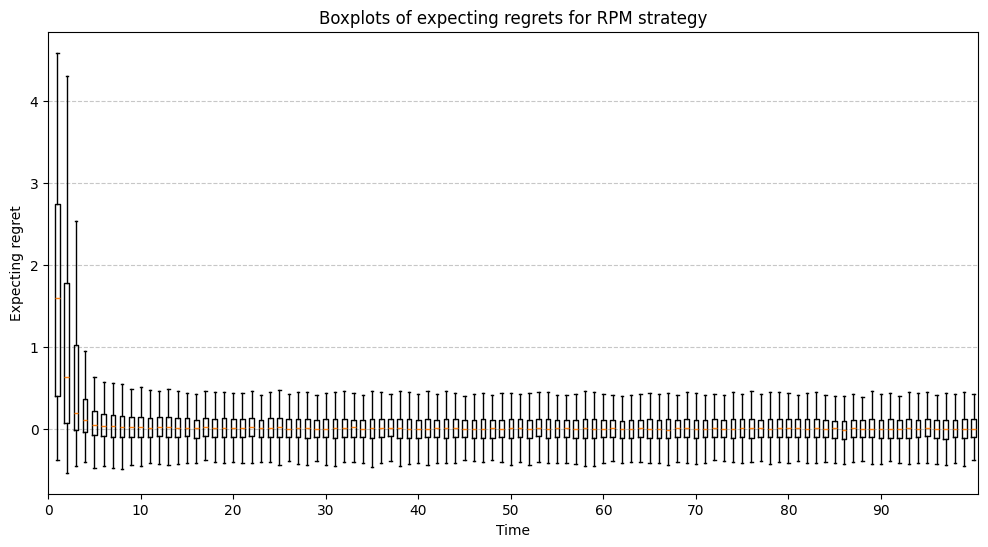

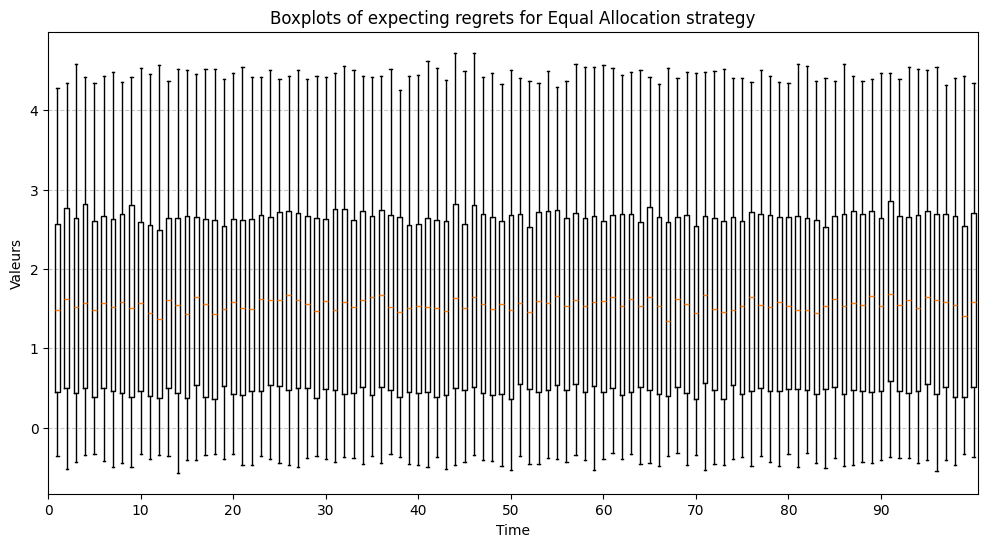

In [71]:
# Regrouper les données par période
def group_by_period(experiment_data):
  period_data = [[] for _ in range(max(len(lst) for lst in experiment_data))]
  for lst in experiment_data:
      for i, value in enumerate(lst):
          period_data[i].append(value)
  return period_data

rpm_period_data = group_by_period(exp[linRpm.name()])
eq_period_data = group_by_period(exp[linEq.name()])

# Créer le boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(rpm_period_data, showfliers=False)  # showfliers=False pour ne pas afficher les outliers
plt.title("Boxplots of expecting regrets for RPM strategy")
plt.xlabel("Time")
plt.ylabel("Expecting regret")
plt.xticks(ticks=range(0, 100, 10), labels=range(0, 100, 10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Créer le boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(eq_period_data, showfliers=False)  # showfliers=False pour ne pas afficher les outliers
plt.title("Boxplots of expecting regrets for Equal Allocation strategy")
plt.xlabel("Time")
plt.ylabel("Valeurs")
plt.xticks(ticks=range(0, 100, 10), labels=range(0, 100, 10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()